<a href="https://colab.research.google.com/github/MarcotteS/semantic-correspondance/blob/main/notebooks/training_free_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [4]:
import os
import sys
import glob
from tqdm import tqdm
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import torchvision.transforms as transforms
from collections import defaultdict
import pickle
from datetime import datetime
import pandas as pd

# Download and unzip dataset

In [5]:
!wget https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz

--2026-01-08 01:01:36--  https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
Resolving cvlab.postech.ac.kr (cvlab.postech.ac.kr)... 141.223.85.126
Connecting to cvlab.postech.ac.kr (cvlab.postech.ac.kr)|141.223.85.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226961117 (216M) [application/x-gzip]
Saving to: ‘SPair-71k.tar.gz’

SPair-71k.tar.gz    100%[===================>] 216.45M  25.0MB/s    in 9.4s    

2026-01-08 01:01:46 (23.1 MB/s) - ‘SPair-71k.tar.gz’ saved [226961117/226961117]



In [12]:
!tar -xf SPair-71k.tar.gz

# Dataset

In [6]:
class SPairDataset(Dataset):
    """
    SPair-71k dataset for semantic correspondence

    Args:
        datapath: Root path to SPair-71k dataset
        split: 'trn', 'val', or 'test'
        img_size: Size to resize images to (default: 224)
        category: Specific category or 'all' (default: 'all')
        mean: Normalization mean (default: ImageNet)
        std: Normalization std (default: ImageNet)
    """

    CATEGORIES = [
        "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
        "car", "cat", "chair", "cow", "dog", "horse", "motorbike",
        "person", "pottedplant", "sheep", "train", "tvmonitor"
    ]

    CLASS_DICT = {
        'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
        'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
        'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14,
        'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
    }

    def __init__(
        self,
        datapath,
        split='trn',
        img_size=224,
        category='all',
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ):
        super().__init__()

        assert split in ['trn', 'val', 'test'], f"Split must be trn/val/test, got {split}"
        assert category == 'all' or category in self.CATEGORIES, \
            f"Category must be 'all' or one of {self.CATEGORIES}"

        self.split = split
        self.img_size = (img_size, img_size)
        self.max_pts = 20

        # Setup paths
        base_path = os.path.join(os.path.abspath(datapath), 'SPair-71k')
        self.img_path = os.path.join(base_path, 'JPEGImages')
        self.seg_path = os.path.join(base_path, 'Segmentation')
        self.ann_path = os.path.join(base_path, 'PairAnnotation', split)
        split_file = os.path.join(base_path, 'Layout/large', f'{split}.txt')

        # Load pair list
        self.train_data = open(split_file).read().strip().split('\n')

        # Filter by category if needed
        if category != 'all':
            self.train_data = [pair for pair in self.train_data if category in pair]

        # Extract image names
        self.src_imnames = [x.split('-')[1] + '.jpg' for x in self.train_data]
        self.trg_imnames = [x.split('-')[2].split(':')[0] + '.jpg' for x in self.train_data]

        # Get class list
        self.cls = sorted(os.listdir(self.img_path))

        # Setup transforms
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        # Load annotations
        print(f"Loading SPair-71k {split} annotations...")
        anntn_files = [glob.glob(f'{self.ann_path}/{name}.json')[0]
                       for name in self.train_data]

        self.src_kps, self.trg_kps = [], []
        self.src_bbox, self.trg_bbox = [], []
        self.cls_ids = []
        self.kps_ids = []  # Store keypoint IDs
        self.vpvar, self.scvar, self.trncn, self.occln = [], [], [], []

        for anntn_file in tqdm(anntn_files):
            with open(anntn_file) as f:
                anntn = json.load(f)

            self.src_kps.append(torch.tensor(anntn['src_kps']).t().float())
            self.trg_kps.append(torch.tensor(anntn['trg_kps']).t().float())
            self.src_bbox.append(torch.tensor(anntn['src_bndbox']).float())
            self.trg_bbox.append(torch.tensor(anntn['trg_bndbox']).float())
            self.cls_ids.append(self.cls.index(anntn['category']))

            # Store keypoint IDs (as strings)
            self.kps_ids.append(anntn.get('kps_ids', []))

            self.vpvar.append(torch.tensor(anntn['viewpoint_variation']))
            self.scvar.append(torch.tensor(anntn['scale_variation']))
            self.trncn.append(torch.tensor(anntn['truncation']))
            self.occln.append(torch.tensor(anntn['occlusion']))

        # Create unique identifiers
        self.src_identifiers = [f"{self.cls[ids]}-{name[:-4]}"
                                for ids, name in zip(self.cls_ids, self.src_imnames)]
        self.trg_identifiers = [f"{self.cls[ids]}-{name[:-4]}"
                                for ids, name in zip(self.cls_ids, self.trg_imnames)]

    def __len__(self):
        return len(self.src_imnames)

    def __getitem__(self, idx):
        """Return a sample pair"""
        batch = {}

        # Image names and category
        batch['src_imname'] = self.src_imnames[idx]
        batch['trg_imname'] = self.trg_imnames[idx]
        batch['category_id'] = self.cls_ids[idx]
        batch['category'] = self.cls[batch['category_id']]
        batch['pair_idx'] = idx  # Add pair index for per-image tracking

        # Load images
        src_pil = self._get_image(self.src_imnames[idx], batch['category_id'])
        trg_pil = self._get_image(self.trg_imnames[idx], batch['category_id'])
        batch['src_imsize'] = src_pil.size  # (W, H)
        batch['trg_imsize'] = trg_pil.size

        # Transform images
        batch['src_img'] = self.transform(src_pil)
        batch['trg_img'] = self.transform(trg_pil)

        h1, w1 = batch['src_img'].shape[1:]
        h2, w2 = batch['trg_img'].shape[1:]

        # Load masks
        batch['src_mask'] = self._get_mask(batch['category'], batch['src_imname'], (h1, w1))
        batch['trg_mask'] = self._get_mask(batch['category'], batch['trg_imname'], (h2, w2))

        # Scale bounding boxes
        batch['src_bbox'] = self._scale_bbox(self.src_bbox[idx], batch['src_imsize'], (h1, w1))
        batch['trg_bbox'] = self._scale_bbox(self.trg_bbox[idx], batch['trg_imsize'], (h2, w2))

        # Scale keypoints
        batch['src_kps'], num_pts = self._get_points(
            self.src_kps[idx], batch['src_imsize'], (h1, w1))
        batch['trg_kps'], _ = self._get_points(
            self.trg_kps[idx], batch['trg_imsize'], (h2, w2))
        batch['n_pts'] = torch.tensor(num_pts)

        # Convert keypoints from 2xN to Nx2
        batch['src_kps'] = batch['src_kps'].permute(1, 0)
        batch['trg_kps'] = batch['trg_kps'].permute(1, 0)

        # Regularize coordinates
        batch['src_kps'][:num_pts] = self._regularise_coordinates(
            batch['src_kps'][:num_pts], h1, w1, eps=1e-4)
        batch['trg_kps'][:num_pts] = self._regularise_coordinates(
            batch['trg_kps'][:num_pts], h2, w2, eps=1e-4)

        # Pad keypoint IDs to max_pts (use "-1" as sentinel for invalid)
        kps_ids = self.kps_ids[idx][:num_pts]  # Only take valid keypoints
        # Pad to max_pts
        padded_kps_ids = kps_ids + ["-1"] * (self.max_pts - len(kps_ids))
        batch['kps_ids'] = padded_kps_ids

        # PCK thresholds (using bbox)
        batch['src_pckthres'] = self._get_pckthres(batch['src_bbox'])
        batch['trg_pckthres'] = self._get_pckthres(batch['trg_bbox'])
        batch['pckthres'] = batch['trg_pckthres'].clone()

        # Additional metadata
        batch['vpvar'] = self.vpvar[idx]
        batch['scvar'] = self.scvar[idx]
        batch['trncn'] = self.trncn[idx]
        batch['occln'] = self.occln[idx]
        batch['src_identifier'] = self.src_identifiers[idx]
        batch['trg_identifier'] = self.trg_identifiers[idx]
        batch['datalen'] = len(self.train_data)

        return batch

    def _get_image(self, imname, cls_id):
        """Load image from disk"""
        path = os.path.join(self.img_path, self.cls[cls_id], imname)
        return Image.open(path).convert('RGB')

    def _get_mask(self, category, imname, scaled_imsize):
        """Load and process segmentation mask"""
        mask_path = os.path.join(self.seg_path, category, imname.split('.')[0] + '.png')
        tensor_mask = torch.tensor(np.array(Image.open(mask_path)))

        # Filter to only the target class
        class_id = self.CLASS_DICT[category] + 1
        tensor_mask = (tensor_mask == class_id).float() * 255

        # Resize mask
        tensor_mask = F.interpolate(
            tensor_mask.unsqueeze(0).unsqueeze(0),
            size=scaled_imsize,
            mode='bilinear',
            align_corners=True
        ).int().squeeze()

        return tensor_mask

    def _scale_bbox(self, bbox, ori_imsize, scaled_imsize):
        """Scale bounding box from original to scaled image size"""
        bbox = bbox.clone()
        bbox[0::2] *= scaled_imsize[1] / ori_imsize[0]  # x coordinates
        bbox[1::2] *= scaled_imsize[0] / ori_imsize[1]  # y coordinates
        return bbox

    def _get_points(self, pts, ori_imsize, scaled_imsize):
        """Scale keypoints and pad to max_pts"""
        xy, n_pts = pts.size()
        pad_pts = torch.zeros((xy, self.max_pts - n_pts)) - 2

        x_crds = pts[0] * (scaled_imsize[1] / ori_imsize[0])
        y_crds = pts[1] * (scaled_imsize[0] / ori_imsize[1])
        kps = torch.cat([torch.stack([x_crds, y_crds]), pad_pts], dim=1)

        return kps, n_pts

    def _get_pckthres(self, bbox):
        """Compute PCK threshold from bounding box"""
        if len(bbox.shape) == 2:
            bbox = bbox.squeeze(0)
        bbox_w = bbox[2] - bbox[0]
        bbox_h = bbox[3] - bbox[1]
        return torch.max(bbox_w, bbox_h).float()

    def _regularise_coordinates(self, coord, H, W, eps=0):
        """Clamp coordinates to image boundaries"""
        coord = coord.clone()
        coord[..., 0] = torch.clamp(coord[..., 0], min=0+eps, max=W-1-eps)
        coord[..., 1] = torch.clamp(coord[..., 1], min=0+eps, max=H-1-eps)
        return coord

In [8]:
# functions for visualising samples with keypoints
def denorm(img_chw, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    mean = torch.tensor(mean)[:, None, None]
    std  = torch.tensor(std)[:, None, None]
    x = img_chw.cpu() * std + mean
    return x.clamp(0, 1)

def draw_image_with_keypoints(
    ax,
    image,
    keypoints,
    title=None,
    colors=None,
    kp_size=35,
    show_indices=True,
    fontsize=9
):
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis("off")

    n = keypoints.shape[0]

    for i in range(n):
        c = colors[i] if colors is not None else None

        ax.scatter(
            keypoints[i, 0],
            keypoints[i, 1],
            s=kp_size,
            color=c
        )

        if show_indices:
            ax.text(
                keypoints[i, 0] + 2,
                keypoints[i, 1] + 2,
                str(i),
                fontsize=fontsize,
                color="white",
                bbox=dict(
                    facecolor="black",
                    alpha=0.5,
                    pad=1,
                    edgecolor="none"
                ),
            )


def visualize_sample(
    ds,
    idx=None,
    kp_size=35,
    show_indices=True,
    use_colors=True,
    fontsize=9
):
    if idx is None:
        idx = random.randrange(len(ds))

    b = ds[idx]
    n = int(b["n_pts"].item())

    src = denorm(b["src_img"]).permute(1, 2, 0).numpy()
    trg = denorm(b["trg_img"]).permute(1, 2, 0).numpy()

    src_kps = b["src_kps"][:n].cpu()
    trg_kps = b["trg_kps"][:n].cpu()

    # Same color per keypoint index across both images
    if use_colors:
        cmap = plt.get_cmap("tab20")
        colors = [cmap(i % 20) for i in range(n)]
    else:
        colors = None

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    draw_image_with_keypoints(
        ax[0],
        src,
        src_kps,
        title=f"SRC ({b['category']}) idx={idx}",
        colors=colors,
        kp_size=kp_size,
        show_indices=show_indices,
        fontsize=fontsize,
    )

    draw_image_with_keypoints(
        ax[1],
        trg,
        trg_kps,
        title="TRG",
        colors=colors,
        kp_size=kp_size,
        show_indices=show_indices,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

# Models

In [22]:

class DINOv2Extractor:
    def __init__(self, model_name="dinov2_vitb14"):
        self.model = torch.hub.load("facebookresearch/dinov2", model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.patch_size = self.model.patch_size

    def extract(self, img: torch.Tensor, no_grad: bool = True):
        """
        Extract features from image(s).

        Args:
            img: [3,H,W] or [B,3,H,W]
            no_grad: True for inference/eval, False for fine-tuning (keeps gradients)

        Returns:
            features: [B, H_p*W_p, D]
            (H_p, W_p)
        """
        # Ensure batch dimension
        if img.dim() == 3:
            img = img.unsqueeze(0)

        assert img.dim() == 4, f"Expected 4D tensor, got {img.dim()}D"
        B, C, H, W = img.shape
        assert C == 3, f"Expected 3 channels, got {C}"

        img = img.to(self.device)

        # mode: en training loop tu gères model.train(), sinon eval
        if no_grad:
            self.model.eval()
            with torch.no_grad():
                out = self.model.forward_features(img)
        else:
            # IMPORTANT: pas de no_grad ici
            out = self.model.forward_features(img)

        features = out["x_norm_patchtokens"]

        H_p = H // self.patch_size
        W_p = W // self.patch_size

        return features, (H_p, W_p)


class DINOv3Extractor:
    def __init__(self, model_name="dinov3_vitb16",
                 repo_dir="<PATH/TO/A/LOCAL/DIRECTORY/WHERE/THE/DINOV3/REPO/WAS/CLONED>",
                 weights="<CHECKPOINT/URL/OR/PATH>", ):
        """Initialize DINOv3 feature extractor."""
        self.model = torch.hub.load(repo_dir, model_name, source="local", weights=weights)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()
        self.patch_size = self.model.patch_size

    @torch.no_grad()
    def extract(self, img: torch.Tensor):
        """
        Extract features from image(s).

        Args:
            img: torch.Tensor of shape:
                - [3, H, W] for single image
                - [B, 3, H, W] for batch of images
                All images must have the same H, W (already resized/normalized)

        Returns:
            features: torch.Tensor [B, H_p*W_p, D] - patch token features
            spatial_dims: tuple (H_p, W_p) - spatial patch grid size
        """
        # Ensure batch dimension
        if img.dim() == 3:
            img = img.unsqueeze(0)  # [1, 3, H, W]

        assert img.dim() == 4, f"Expected 4D tensor, got {img.dim()}D"
        B, C, H, W = img.shape
        assert C == 3, f"Expected 3 channels, got {C}"

        img = img.to(self.device)

        # Forward pass
        out = self.model.forward_features(img)

        # Extract patch tokens (shape: [B, H_p*W_p, D])
        features = out["x_norm_patchtokens"]

        H_p = H // self.patch_size
        W_p = W // self.patch_size

        return features, (H_p, W_p)

class SAMExtractor:
    def __init__(self, model_type="vit_b", checkpoint_path="sam_vit_b_01ec64.pth"):
        """
        Initialize SAM (Segment Anything Model) feature extractor.

        Args:
            model_type: SAM model type ('vit_b', 'vit_l', 'vit_h')
            checkpoint_path: Path to SAM checkpoint file
        """
        from segment_anything import sam_model_registry

        self.model = sam_model_registry[model_type](checkpoint=checkpoint_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()

        # SAM's image encoder outputs 64x64 patches for 1024x1024 input
        # So patch_size = 1024 / 64 = 16
        self.patch_size = 16
        self.required_size = 1024

    @torch.no_grad()
    def extract(self, img: torch.Tensor):
        """
        Extract features from image(s).

        Args:
            img: torch.Tensor of shape:
                - [3, 1024, 1024] for single image
                - [B, 3, 1024, 1024] for batch of images
                SAM requires images to be exactly 1024x1024

        Returns:
            features: torch.Tensor [B, H_p*W_p, D] - patch token features
            spatial_dims: tuple (H_p, W_p) - spatial patch grid size
        """
        # Ensure batch dimension
        if img.dim() == 3:
            img = img.unsqueeze(0)  # [1, 3, H, W]

        assert img.dim() == 4, f"Expected 4D tensor, got {img.dim()}D"
        B, C, H, W = img.shape
        assert C == 3, f"Expected 3 channels, got {C}"
        assert H == self.required_size and W == self.required_size, \
            f"SAM requires {self.required_size}x{self.required_size} images, got {H}x{W}"

        img = img.to(self.device)

        # Forward pass through SAM's image encoder
        # Output shape: [B, D, H_p, W_p] (e.g., [B, 256, 64, 64])
        features = self.model.image_encoder(img)

        B, D, H_p, W_p = features.shape

        # Reshape to match DINO format: [B, H_p*W_p, D]
        # Permute [B, D, H_p, W_p] -> [B, H_p, W_p, D]
        # Then reshape to [B, H_p*W_p, D]
        features = features.permute(0, 2, 3, 1).reshape(B, H_p * W_p, D)

        return features, (H_p, W_p)

# Correspondence Matcher

In [14]:
class CorrespondenceMatcher:
    """
    Handles correspondence matching between source and target features
    Supports batched inputs and vectorized matching.
    """

    def __init__(self, feature_extractor):
        """
        Args:
            feature_extractor: DINOv2Extractor or similar
        """
        self.extractor = feature_extractor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def find_correspondences(self, src_img, trg_img, src_kps):
        """
        Find correspondences for source keypoints in target image (Batched & Vectorized)

        Args:
            src_img: torch.Tensor [B, 3, H, W] - source images (normalized)
            trg_img: torch.Tensor [B, 3, H, W] - target images (normalized)
            src_kps: torch.Tensor [B, N, 2] - source keypoints (x, y) in pixels
                     Valid keypoints have positive coordinates, invalid are -2

        Returns:
            pred_kps: torch.Tensor [B, N, 2] - predicted target keypoints
        """
        # 1. Handle Batch Dimensions
        # If inputs are unbatched [3, H, W], unsqueeze to [1, 3, H, W]
        is_batched = src_img.dim() == 4
        if not is_batched:
            src_img = src_img.unsqueeze(0)
            trg_img = trg_img.unsqueeze(0)
            src_kps = src_kps.unsqueeze(0)

        # Move to device
        src_img = src_img.to(self.device)
        trg_img = trg_img.to(self.device)
        src_kps = src_kps.to(self.device)

        B, N, _ = src_kps.shape

        # 2. Extract Features [B, L, D] where L = H_p * W_p
        # DINOv2Extractor handles the batch dimension naturally
        src_feats, (h_p, w_p) = self.extractor.extract(src_img)
        trg_feats, _ = self.extractor.extract(trg_img)

        D = src_feats.shape[-1]
        patch_size = self.extractor.patch_size

        # 3. Normalize Features (L2)
        # Important for cosine similarity: dot product of normalized vectors
        src_feats = F.normalize(src_feats, dim=-1)
        trg_feats = F.normalize(trg_feats, dim=-1)

        # 4. Convert Source Keypoints to Grid Indices
        # Create a mask for valid keypoints (not -2)
        valid_mask = (src_kps[..., 0] >= 0)  # [B, N]

        # Convert pixel coords to patch coords
        # Clamp to ensure indices are within [0, grid_size-1]
        # (This handles the -2 padding safely by clamping them to 0)
        kps_grid = (src_kps / patch_size).long()
        grid_x = kps_grid[..., 0].clamp(0, w_p - 1)
        grid_y = kps_grid[..., 1].clamp(0, h_p - 1)

        # Calculate flat indices [B, N] for gathering
        flat_indices = grid_y * w_p + grid_x

        # 5. Gather Source Features at Keypoint Locations
        # Expand indices to [B, N, D] to match feature dimension
        flat_indices_expanded = flat_indices.unsqueeze(-1).expand(-1, -1, D)

        # Gather: Select specific patch features for each keypoint
        # src_kp_feats shape: [B, N, D]
        src_kp_feats = torch.gather(src_feats, 1, flat_indices_expanded)

        # 6. Compute Similarity Matrix (Batch Matrix Multiplication)
        # [B, N, D] @ [B, D, L] -> [B, N, L]
        # This computes sim between every source keypoint and every target patch
        sim_matrix = torch.bmm(src_kp_feats, trg_feats.transpose(1, 2))

        # 7. Find Best Matches
        # Argmax over the target patch dimension (L)
        best_match_indices = torch.argmax(sim_matrix, dim=-1)  # [B, N]

        # 8. Convert Matches back to Pixels
        pred_y_idx = best_match_indices // w_p
        pred_x_idx = best_match_indices % w_p

        # Scale back to pixel coordinates (center of the patch)
        pred_x_px = (pred_x_idx.float() + 0.5) * patch_size
        pred_y_px = (pred_y_idx.float() + 0.5) * patch_size

        # Stack coordinates [B, N, 2]
        pred_kps = torch.stack([pred_x_px, pred_y_px], dim=-1)

        # 9. Restore Mask for Padding
        # Set predicted keypoints for invalid source points back to -2
        pred_kps[~valid_mask] = -2

        # Remove batch dimension if input was unbatched
        if not is_batched:
            pred_kps = pred_kps.squeeze(0)

        return pred_kps

# Evaluator

In [15]:
class CorrespondenceEvaluator:
    """
    Evaluates semantic correspondence using PCK metric
    """

    def __init__(self, thresholds=[0.05, 0.10, 0.15, 0.20]):
        """
        Args:
            thresholds: List of PCK thresholds (relative to bbox size)
        """
        self.thresholds = thresholds
        self.reset()

    def reset(self):
        """Reset all metrics"""
        # Overall metrics: {threshold: [correct_count, total_count]}
        self.overall = {t: [0, 0] for t in self.thresholds}

        # Per-keypoint metrics: {(category, kp_id): {threshold: [correct, total]}}
        self.per_keypoint = defaultdict(lambda: {t: [0, 0] for t in self.thresholds})

        # Per-image metrics: {pair_idx: {threshold: [correct, total]}}
        self.per_image = defaultdict(lambda: {t: [0, 0] for t in self.thresholds})

        # Per-category metrics: {category: {threshold: [correct, total]}}
        self.per_category = defaultdict(lambda: {t: [0, 0] for t in self.thresholds})

    def compute_pck(self, pred_kps, gt_kps, threshold_value, n_pts):
        """
        Compute PCK for a single sample

        Args:
            pred_kps: torch.Tensor [N, 2] - predicted keypoints (x, y)
            gt_kps: torch.Tensor [N, 2] - ground truth keypoints (x, y)
            threshold_value: float - absolute distance threshold (in pixels)
            n_pts: int - number of valid keypoints

        Returns:
            correct: torch.Tensor [N] - binary mask of correct predictions
            distances: torch.Tensor [N] - L2 distances for valid keypoints
        """
        # Compute L2 distance
        distances = torch.norm(pred_kps - gt_kps, dim=1)  # [N]

        # Check if within threshold
        correct = (distances < threshold_value).float()  # [N]

        # Only consider valid keypoints
        correct[n_pts:] = 0
        distances[n_pts:] = float('inf')

        return correct, distances

    def update(self, pred_kps, batch):
        """
        Update metrics with predictions from a batch

        Args:
            pred_kps: torch.Tensor [N, 2] - predicted keypoints
            batch: dict containing:
                - trg_kps: ground truth target keypoints [N, 2]
                - pckthres: PCK threshold value (bbox max dimension)
                - n_pts: number of valid keypoints
                - kps_ids: list of keypoint semantic IDs (length N)
                - pair_idx: index of this image pair
                - category: category name (e.g., 'cat', 'dog')
        """
        gt_kps = batch['trg_kps']
        n_pts = batch['n_pts'].item()
        pck_thres = batch['pckthres'].item()
        kps_ids = batch['kps_ids']
        pair_idx = batch['pair_idx']
        category = batch['category']

        # Handle kps_ids being a tuple from DataLoader collation
        if isinstance(kps_ids, tuple):
            kps_ids = list(kps_ids)

        # Move to same device
        pred_kps = pred_kps.to(gt_kps.device)

        # Evaluate at each threshold
        for alpha in self.thresholds:
            threshold_value = alpha * pck_thres
            correct, distances = self.compute_pck(pred_kps, gt_kps, threshold_value, n_pts)

            n_correct = correct[:n_pts].sum().item()

            # Update overall metrics
            self.overall[alpha][0] += n_correct
            self.overall[alpha][1] += n_pts

            # Update per-image metrics
            self.per_image[pair_idx][alpha][0] += n_correct
            self.per_image[pair_idx][alpha][1] += n_pts

            # Update per-category metrics
            self.per_category[category][alpha][0] += n_correct
            self.per_category[category][alpha][1] += n_pts

            # Update per-keypoint metrics (with category prefix)
            for kp_idx in range(n_pts):
                kp_id = kps_ids[kp_idx]
                # Handle if kp_id is a tuple (from collate_fn)
                if isinstance(kp_id, tuple):
                    kp_id = kp_id[0]

                if kp_id != "-1":  # Skip padding
                    # Create category-specific keypoint identifier
                    kp_key = (category, kp_id)
                    is_correct = correct[kp_idx].item()
                    self.per_keypoint[kp_key][alpha][0] += is_correct
                    self.per_keypoint[kp_key][alpha][1] += 1

    def get_metrics(self):
        """
        Compute final metrics

        Returns:
            dict with keys:
                - 'overall': {threshold: pck_value}
                - 'per_keypoint': {kp_id: {threshold: pck_value}}
                - 'per_image': {pair_idx: {threshold: pck_value}}
                - 'per_category': {category: {threshold: pck_value}}
        """
        metrics = {}

        # Overall PCK
        metrics['overall'] = {}
        for alpha in self.thresholds:
            correct, total = self.overall[alpha]
            metrics['overall'][alpha] = 100.0 * correct / total if total > 0 else 0.0

        # Per-keypoint PCK
        metrics['per_keypoint'] = {}
        for (category, kp_id), results in self.per_keypoint.items():
            # Store as nested dict: metrics['per_keypoint'][category][kp_id]
            if category not in metrics['per_keypoint']:
                metrics['per_keypoint'][category] = {}
            metrics['per_keypoint'][category][kp_id] = {}
            for alpha in self.thresholds:
                correct, total = results[alpha]
                metrics['per_keypoint'][category][kp_id][alpha] = 100.0 * correct / total if total > 0 else 0.0

        # Per-image PCK
        metrics['per_image'] = {}
        for pair_idx, results in self.per_image.items():
            metrics['per_image'][pair_idx] = {}
            for alpha in self.thresholds:
                correct, total = results[alpha]
                metrics['per_image'][pair_idx][alpha] = 100.0 * correct / total if total > 0 else 0.0

        # Per-category PCK
        metrics['per_category'] = {}
        for category, results in self.per_category.items():
            metrics['per_category'][category] = {}
            for alpha in self.thresholds:
                correct, total = results[alpha]
                metrics['per_category'][category][alpha] = 100.0 * correct / total if total > 0 else 0.0

        return metrics

    def print_summary(self, metrics=None):
        """Print a summary of the evaluation results"""
        if metrics is None:
            metrics = self.get_metrics()

        print("\n" + "="*70)
        print("EVALUATION SUMMARY")
        print("="*70)

        # Overall results
        print("\n📊 Overall PCK:")
        print("-" * 70)
        for alpha in self.thresholds:
            pck = metrics['overall'][alpha]
            print(f"  PCK@{alpha:.2f}: {pck:.2f}%")

        # Per-category results
        print("\n📁 Per-Category PCK:")
        print("-" * 70)
        for category in sorted(metrics['per_category'].keys()):
            pck_str = " | ".join([f"{alpha:.2f}: {metrics['per_category'][category][alpha]:.2f}%"
                                   for alpha in self.thresholds])
            print(f"  {category:15s} → {pck_str}")

        # Per-keypoint results (top 10 best and worst)
        print("\n🎯 Per-Keypoint PCK (at α=0.10):")
        print("-" * 70)

        # Flatten keypoint scores with category context
        kp_scores = []
        for category in metrics['per_keypoint'].keys():
            for kp_id in metrics['per_keypoint'][category].keys():
                pck = metrics['per_keypoint'][category][kp_id][0.10]
                kp_scores.append((category, kp_id, pck))

        kp_scores.sort(key=lambda x: x[2], reverse=True)

        if len(kp_scores) > 0:
            print("  Top 10 easiest keypoints:")
            for category, kp_id, score in kp_scores[:10]:
                print(f"    {category:15s} - Keypoint {kp_id:3s}: {score:.2f}%")

            if len(kp_scores) > 10:
                print("\n  Top 10 hardest keypoints:")
                for category, kp_id, score in kp_scores[-10:]:
                    print(f"    {category:15s} - Keypoint {kp_id:3s}: {score:.2f}%")

        # Per-image statistics
        print("\n🖼️  Per-Image PCK Statistics (at α=0.10):")
        print("-" * 70)
        image_scores = [metrics['per_image'][idx][0.10] for idx in metrics['per_image'].keys()]
        if len(image_scores) > 0:
            print(f"  Mean:   {np.mean(image_scores):.2f}%")
            print(f"  Median: {np.median(image_scores):.2f}%")
            print(f"  Std:    {np.std(image_scores):.2f}%")
            print(f"  Min:    {np.min(image_scores):.2f}%")
            print(f"  Max:    {np.max(image_scores):.2f}%")

        print("\n" + "="*70)

In [16]:
def evaluate_model(matcher, dataloader):
    """
    Evaluate correspondence matcher on a dataset.
    """
    evaluator = CorrespondenceEvaluator(thresholds=[0.05, 0.10, 0.15, 0.20])
    matcher.extractor.model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src_img = batch['src_img']      # [B, 3, H, W]
            trg_img = batch['trg_img']      # [B, 3, H, W]
            src_kps = batch['src_kps']      # [B, N, 2]

            # Find correspondences (batched)
            pred_kps = matcher.find_correspondences(src_img, trg_img, src_kps)  # [B, N, 2]

            # Process each sample in batch
            batch_size = src_img.shape[0]
            for b in range(batch_size):
                # Extract single sample
                pred_kps_b = pred_kps[b]
                trg_kps_b = batch['trg_kps'][b]
                n_pts_b = batch['n_pts'][b]
                pckthres_b = batch['pckthres'][b]
                kps_ids_b = batch['kps_ids'][b]
                pair_idx_b = batch['pair_idx'][b]
                category_b = batch['category'][b]

                # Prepare batch dict for evaluator
                batch_single = {
                    'trg_kps': trg_kps_b,
                    'pckthres': pckthres_b,
                    'n_pts': n_pts_b,
                    'kps_ids': kps_ids_b,
                    'pair_idx': pair_idx_b,
                    'category': category_b,
                }

                evaluator.update(pred_kps_b, batch_single)

    metrics = evaluator.get_metrics()
    evaluator.print_summary(metrics)

    return metrics

In [17]:
def collate_fn_correspondence(batch):
    """
    Custom collate function for batching correspondence samples.
    Handles variable-length keypoint IDs properly.

    Args:
        batch: list of dicts from SPairDataset.__getitem__()

    Returns:
        dict with batched tensors and lists for variable-length data
    """
    # Stack image tensors
    src_imgs = torch.stack([b['src_img'] for b in batch])
    trg_imgs = torch.stack([b['trg_img'] for b in batch])

    # Stack keypoint tensors
    src_kps = torch.stack([b['src_kps'] for b in batch])
    trg_kps = torch.stack([b['trg_kps'] for b in batch])

    # Stack masks and bboxes
    src_masks = torch.stack([b['src_mask'] for b in batch])
    trg_masks = torch.stack([b['trg_mask'] for b in batch])
    src_bboxes = torch.stack([b['src_bbox'] for b in batch])
    trg_bboxes = torch.stack([b['trg_bbox'] for b in batch])

    # Stack scalar tensors
    n_pts = torch.stack([b['n_pts'] for b in batch])
    pckthres = torch.stack([b['pckthres'] for b in batch])

    # Stack metadata tensors
    vpvar = torch.stack([b['vpvar'] for b in batch])
    scvar = torch.stack([b['scvar'] for b in batch])
    trncn = torch.stack([b['trncn'] for b in batch])
    occln = torch.stack([b['occln'] for b in batch])

    # Keep non-tensor data as lists
    src_imnames = [b['src_imname'] for b in batch]
    trg_imnames = [b['trg_imname'] for b in batch]
    categories = [b['category'] for b in batch]
    pair_indices = [b['pair_idx'] for b in batch]
    src_identifiers = [b['src_identifier'] for b in batch]
    trg_identifiers = [b['trg_identifier'] for b in batch]

    # Handle kps_ids: keep as list of lists (one list per sample in batch)
    kps_ids_list = [b['kps_ids'] for b in batch]

    # Store image sizes
    src_imsizes = [b['src_imsize'] for b in batch]
    trg_imsizes = [b['trg_imsize'] for b in batch]

    return {
        'src_img': src_imgs,
        'trg_img': trg_imgs,
        'src_kps': src_kps,
        'trg_kps': trg_kps,
        'src_mask': src_masks,
        'trg_mask': trg_masks,
        'src_bbox': src_bboxes,
        'trg_bbox': trg_bboxes,
        'n_pts': n_pts,
        'pckthres': pckthres,
        'vpvar': vpvar,
        'scvar': scvar,
        'trncn': trncn,
        'occln': occln,
        'src_imname': src_imnames,
        'trg_imname': trg_imnames,
        'category': categories,
        'pair_idx': pair_indices,
        'src_identifier': src_identifiers,
        'trg_identifier': trg_identifiers,
        'kps_ids': kps_ids_list,
        'src_imsize': src_imsizes,
        'trg_imsize': trg_imsizes,
    }

In [18]:
class ResultsAnalyzer:
    """
    Analyze and visualize correspondence evaluation results
    """

    def __init__(self, metrics):
        """
        Args:
            metrics: dict returned by CorrespondenceEvaluator.get_metrics()
        """
        self.metrics = metrics

    def plot_pck_curve(self, save_path=None):
        """Plot PCK values across different thresholds"""
        fig, ax = plt.subplots(figsize=(10, 6))

        thresholds = sorted(self.metrics['overall'].keys())
        pck_values = [self.metrics['overall'][t] for t in thresholds]

        ax.plot(thresholds, pck_values, marker='o', linewidth=2, markersize=8)
        ax.set_xlabel('PCK Threshold (α)', fontsize=12)
        ax.set_ylabel('PCK (%)', fontsize=12)
        ax.set_title('PCK vs Threshold', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 100])

        # Add value labels
        for t, pck in zip(thresholds, pck_values):
            ax.text(t, pck + 2, f'{pck:.1f}%', ha='center', fontsize=9)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_per_category(self, threshold=0.10, save_path=None):
        """Plot PCK per category"""
        fig, ax = plt.subplots(figsize=(12, 6))

        categories = sorted(self.metrics['per_category'].keys())
        pck_values = [self.metrics['per_category'][cat][threshold] for cat in categories]

        colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
        bars = ax.bar(range(len(categories)), pck_values, color=colors, alpha=0.8)

        ax.set_xlabel('Category', fontsize=12)
        ax.set_ylabel(f'PCK@{threshold:.2f} (%)', fontsize=12)
        ax.set_title(f'Per-Category Performance (PCK@{threshold:.2f})',
                     fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(categories)))
        ax.set_xticklabels(categories, rotation=45, ha='right')
        ax.set_ylim([0, 100])
        ax.grid(True, axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, val in zip(bars, pck_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_keypoint_difficulty(self, threshold=0.10, top_n=15, save_path=None):
        """Plot keypoint difficulty (top easiest and hardest)"""
        # Flatten keypoint scores with category context
        kp_scores = []
        for category in self.metrics['per_keypoint'].keys():
            for kp_id in self.metrics['per_keypoint'][category].keys():
                pck = self.metrics['per_keypoint'][category][kp_id][threshold]
                kp_label = f"{category}-{kp_id}"
                kp_scores.append((kp_label, pck))

        kp_scores.sort(key=lambda x: x[1])

        # Get top N hardest and easiest
        hardest = kp_scores[:top_n]
        easiest = kp_scores[-top_n:][::-1]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Hardest keypoints
        kp_labels_hard = [kp for kp, _ in hardest]
        scores_hard = [score for _, score in hardest]
        ax1.barh(range(len(hardest)), scores_hard, color='crimson', alpha=0.7)
        ax1.set_yticks(range(len(hardest)))
        ax1.set_yticklabels(kp_labels_hard, fontsize=9)
        ax1.set_xlabel(f'PCK@{threshold:.2f} (%)', fontsize=12)
        ax1.set_title(f'Top {top_n} Hardest Keypoints', fontsize=14, fontweight='bold')
        ax1.set_xlim([0, 100])
        ax1.grid(True, axis='x', alpha=0.3)

        # Add value labels
        for i, val in enumerate(scores_hard):
            ax1.text(val + 2, i, f'{val:.1f}%', va='center', fontsize=9)

        # Easiest keypoints
        kp_labels_easy = [kp for kp, _ in easiest]
        scores_easy = [score for _, score in easiest]
        ax2.barh(range(len(easiest)), scores_easy, color='mediumseagreen', alpha=0.7)
        ax2.set_yticks(range(len(easiest)))
        ax2.set_yticklabels(kp_labels_easy, fontsize=9)
        ax2.set_xlabel(f'PCK@{threshold:.2f} (%)', fontsize=12)
        ax2.set_title(f'Top {top_n} Easiest Keypoints', fontsize=14, fontweight='bold')
        ax2.set_xlim([0, 100])
        ax2.grid(True, axis='x', alpha=0.3)

        # Add value labels
        for i, val in enumerate(scores_easy):
            ax2.text(val + 2, i, f'{val:.1f}%', va='center', fontsize=9)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_image_difficulty_distribution(self, threshold=0.10, save_path=None):
        """Plot distribution of per-image PCK scores"""
        image_scores = [self.metrics['per_image'][idx][threshold]
                       for idx in self.metrics['per_image'].keys()]

        fig, ax = plt.subplots(figsize=(10, 6))

        ax.hist(image_scores, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax.axvline(np.mean(image_scores), color='red', linestyle='--',
                  linewidth=2, label=f'Mean: {np.mean(image_scores):.1f}%')
        ax.axvline(np.median(image_scores), color='green', linestyle='--',
                  linewidth=2, label=f'Median: {np.median(image_scores):.1f}%')

        ax.set_xlabel(f'PCK@{threshold:.2f} (%)', fontsize=12)
        ax.set_ylabel('Number of Image Pairs', fontsize=12)
        ax.set_title('Distribution of Per-Image PCK Scores',
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_per_category_keypoints(self, category, threshold=0.10, save_path=None):
        """Plot keypoint performance for a specific category"""
        if category not in self.metrics['per_keypoint']:
            print(f"Category '{category}' not found in results.")
            return

        kp_data = self.metrics['per_keypoint'][category]
        kp_ids = sorted(kp_data.keys(), key=lambda x: kp_data[x][threshold], reverse=True)
        pck_values = [kp_data[kp_id][threshold] for kp_id in kp_ids]

        fig, ax = plt.subplots(figsize=(12, 6))

        colors = plt.cm.RdYlGn(np.array(pck_values) / 100)
        bars = ax.bar(range(len(kp_ids)), pck_values, color=colors, alpha=0.8, edgecolor='black')

        ax.set_xlabel('Keypoint ID', fontsize=12)
        ax.set_ylabel(f'PCK@{threshold:.2f} (%)', fontsize=12)
        ax.set_title(f'Per-Keypoint Performance for {category.capitalize()}',
                     fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(kp_ids)))
        ax.set_xticklabels(kp_ids, rotation=0)
        ax.set_ylim([0, 100])
        ax.grid(True, axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, val in zip(bars, pck_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def create_summary_table(self, threshold=0.10):
        """Create a pandas DataFrame with summary statistics"""
        data = {
            'Overall PCK': [self.metrics['overall'][threshold]],
        }

        # Add per-category stats
        for cat in sorted(self.metrics['per_category'].keys()):
            data[f'{cat}'] = [self.metrics['per_category'][cat][threshold]]

        df = pd.DataFrame(data)
        return df

    def export_to_csv(self, save_dir='./results'):
        """Export all metrics to CSV files"""
        import os
        os.makedirs(save_dir, exist_ok=True)

        # Overall PCK
        overall_df = pd.DataFrame([
            {'threshold': t, 'pck': self.metrics['overall'][t]}
            for t in sorted(self.metrics['overall'].keys())
        ])
        overall_df.to_csv(f'{save_dir}/overall_pck.csv', index=False)

        # Per-category PCK
        category_data = []
        for cat in sorted(self.metrics['per_category'].keys()):
            for t in sorted(self.metrics['overall'].keys()):
                category_data.append({
                    'category': cat,
                    'threshold': t,
                    'pck': self.metrics['per_category'][cat][t]
                })
        category_df = pd.DataFrame(category_data)
        category_df.to_csv(f'{save_dir}/per_category_pck.csv', index=False)

        # Per-keypoint PCK (now with category)
        keypoint_data = []
        for category in sorted(self.metrics['per_keypoint'].keys()):
            for kp_id in sorted(self.metrics['per_keypoint'][category].keys()):
                for t in sorted(self.metrics['overall'].keys()):
                    keypoint_data.append({
                        'category': category,
                        'keypoint_id': kp_id,
                        'threshold': t,
                        'pck': self.metrics['per_keypoint'][category][kp_id][t]
                    })
        keypoint_df = pd.DataFrame(keypoint_data)
        keypoint_df.to_csv(f'{save_dir}/per_keypoint_pck.csv', index=False)

        # Per-image PCK
        image_data = []
        for idx in sorted(self.metrics['per_image'].keys()):
            for t in sorted(self.metrics['overall'].keys()):
                image_data.append({
                    'pair_idx': idx,
                    'threshold': t,
                    'pck': self.metrics['per_image'][idx][t]
                })
        image_df = pd.DataFrame(image_data)
        image_df.to_csv(f'{save_dir}/per_image_pck.csv', index=False)

        print(f"✅ Exported all metrics to {save_dir}/")

    def generate_report(self, save_dir='./results'):
        """Generate a complete visual report"""
        import os
        os.makedirs(save_dir, exist_ok=True)

        print("📊 Generating visual report...")

        self.plot_pck_curve(save_path=f'{save_dir}/pck_curve.png')
        self.plot_per_category(save_path=f'{save_dir}/per_category.png')
        self.plot_keypoint_difficulty(save_path=f'{save_dir}/keypoint_difficulty.png')
        self.plot_image_difficulty_distribution(save_path=f'{save_dir}/image_distribution.png')
        self.export_to_csv(save_dir=save_dir)

        print(f"✅ Report generated in {save_dir}/")

# DINOv2

In [ ]:
image_size = 224 # Images must be multiples of 14 for DINOv2 or 16 for DINOv3.
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='all'
    )

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:01<00:00, 6144.84it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Initialize model (DINOv2)
extractor = DINOv2Extractor(model_name="dinov2_vitb14")
matcher = CorrespondenceMatcher(extractor)

# Evaluate
metrics = evaluate_model(matcher, dataloader)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:03<00:00, 98.5MB/s]
Evaluating: 100%|██████████| 765/765 [05:55<00:00,  2.15it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 20.37%
  PCK@0.10: 42.46%
  PCK@0.15: 55.20%
  PCK@0.20: 63.81%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 32.66% | 0.10: 58.60% | 0.15: 69.77% | 0.20: 77.84%
  bicycle         → 0.05: 22.68% | 0.10: 49.22% | 0.15: 61.61% | 0.20: 69.24%
  bird            → 0.05: 31.49% | 0.10: 66.47% | 0.15: 80.68% | 0.20: 87.83%
  boat            → 0.05: 10.78% | 0.10: 26.28% | 0.15: 39.49% | 0.20: 47.67%
  bottle          → 0.05: 13.75% | 0.10: 32.56% | 0.15: 44.21% | 0.20: 52.85%
  bus             → 0.05: 16.70% | 0.10: 34.75% | 0.15: 44.64% | 0.20: 51.76%
  car             → 0.05: 18.49% | 0.10: 38.14% | 0.15: 49.44% | 0.20: 56.57%
  cat             → 0.05: 39.03% | 0.10: 62.42% | 0.15: 71.56% | 0.20: 77.61%
  chair           → 0.05: 12.65% | 0.10: 27.82% | 0.15: 39.05% | 0.20: 48.41%
  cow             → 0.0

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov2_vitb14"

results_dict = {
    'metrics': metrics,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")

Results saved!


📊 Generating visual report...


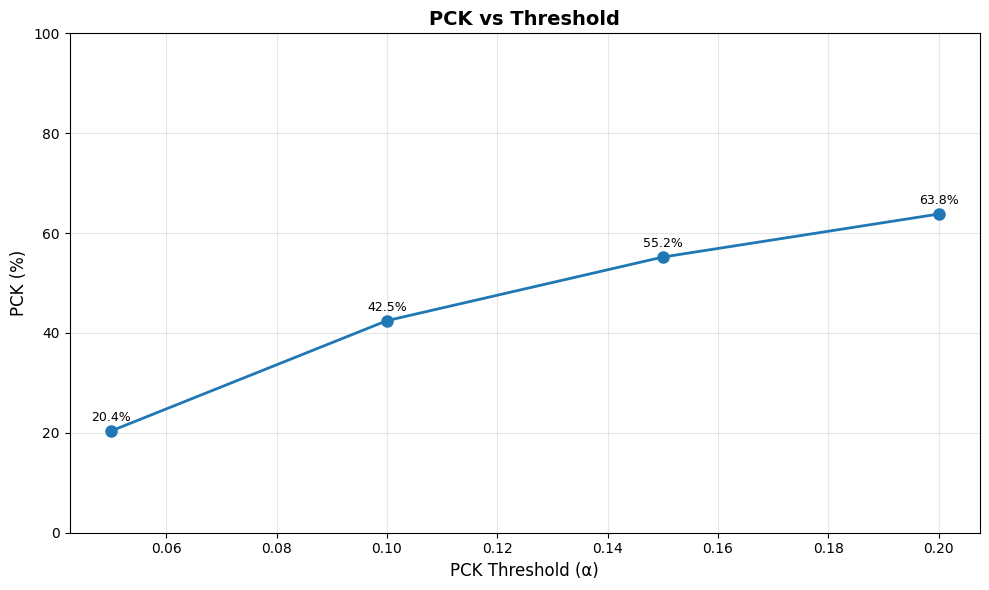

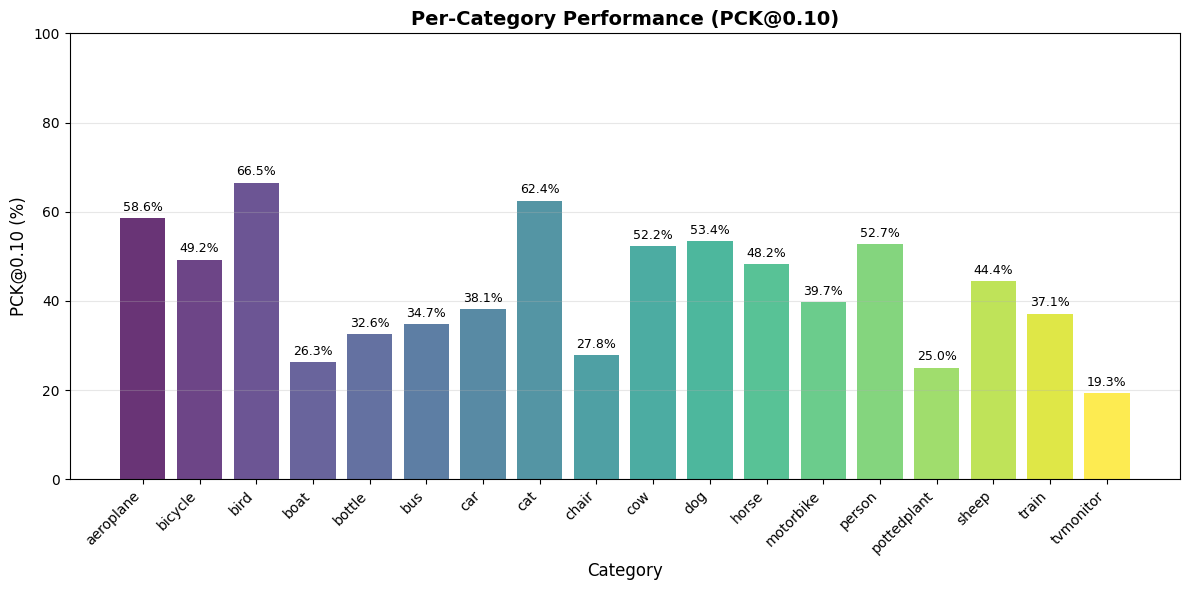

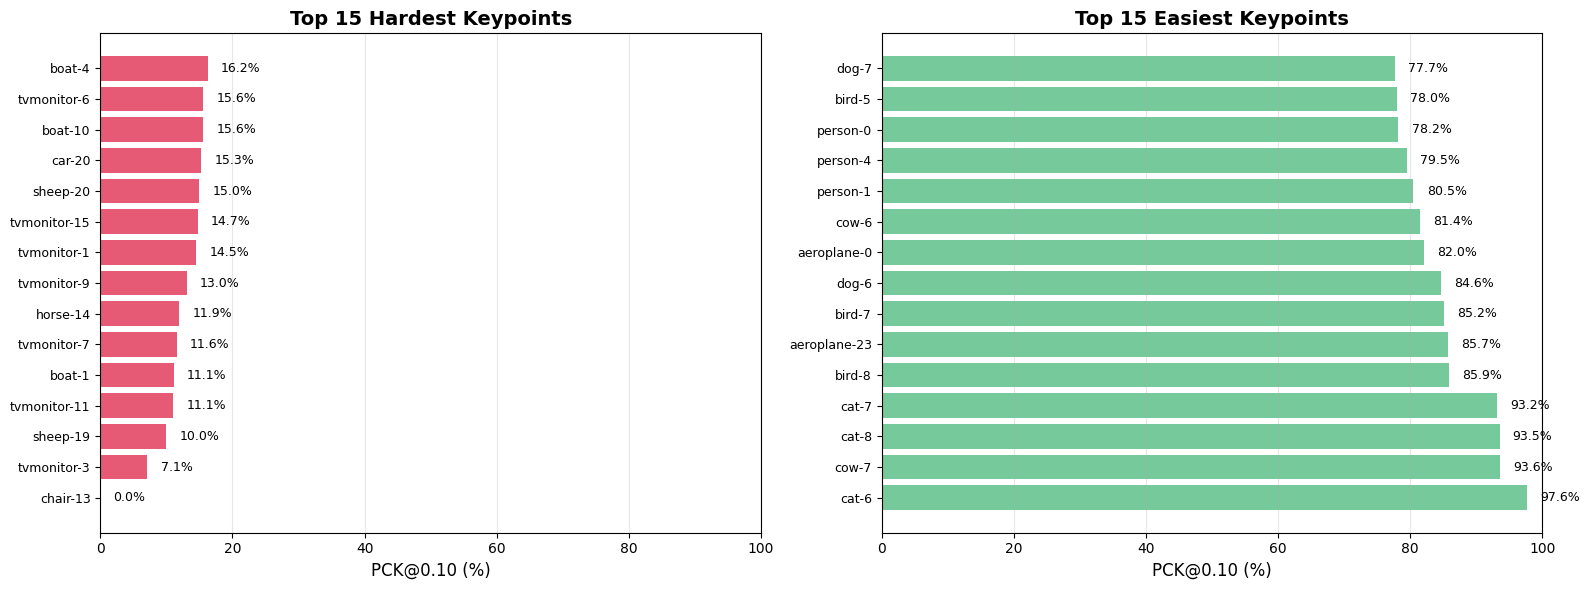

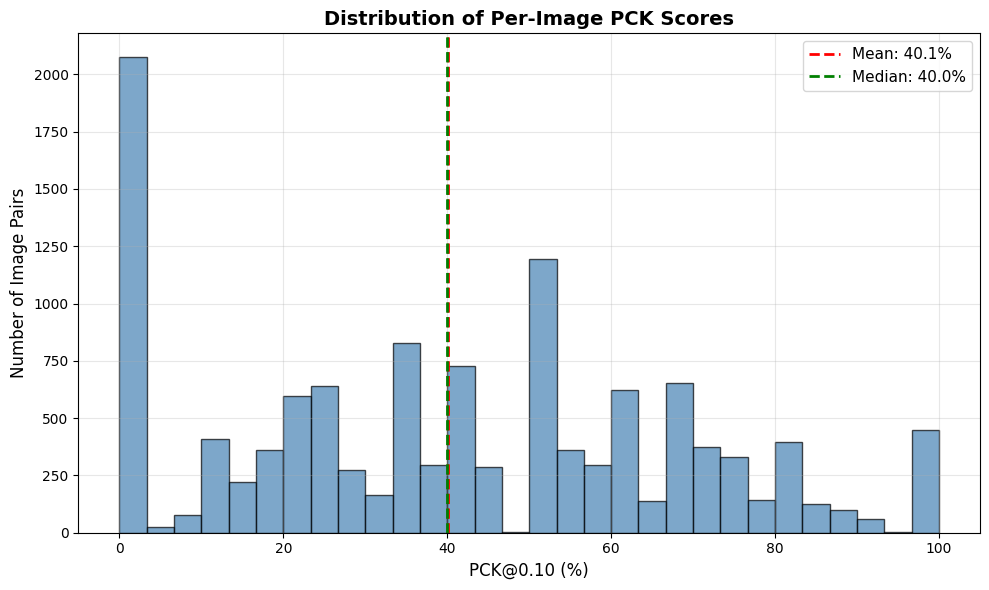

✅ Exported all metrics to ./results/dinov2_vitb14/
✅ Report generated in ./results/dinov2_vitb14/
   Overall PCK  aeroplane    bicycle       bird       boat    bottle  \
0    42.459922  58.596874  49.224004  66.467341  26.284702  32.55995   

         bus        car        cat      chair        cow        dog  \
0  34.747655  38.140312  62.423362  27.820372  52.220978  53.436068   

       horse  motorbike     person  pottedplant      sheep      train  \
0  48.193027  39.711934  52.653631    25.022143  44.447368  37.147806   

   tvmonitor  
0  19.262184  


In [ ]:
analyzer = ResultsAnalyzer(metrics)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/dinov2_vitb14')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)

# DINOv3

In [ ]:
!git clone https://github.com/facebookresearch/dinov3.git

Cloning into 'dinov3'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 538 (delta 201), reused 99 (delta 99), pack-reused 175 (from 1)
Receiving objects: 100% (538/538), 9.88 MiB | 25.88 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.5 MB/s eta 0:00:00


In [ ]:
# You need to go to DINOv3 repo and from download section request for access and put the URL here or just use my link
checkpoint_path = "https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiNmt0Y2lrdHZodmt4dG92dm41ajZrNmdsIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3Njc3NDM4ODZ9fX1dfQ__&Signature=Oo15SCsLwsN9zW-rhSAzIkZGaRPl3VBGnzOjgpGgs8zJC5RsjAPjaA2emXitvCNWCUDkBkxO-wrYyhLVjR5LB9euV7S4dPRunVY1W1tIqH7hbfgQJtNJis3hdz0SDJe4YRQc6BU3GEKxal5m7d69lIBcz3BPyTE9FWkgcbKgOLESrZuY32zmZFhQrpr7TaQQbUjBY9XWb2ais8B5FjgrcuEOj%7E5ECznFTRSsfc57Ai1WtVjt5UD-jSJPahxsPj2EMbe3TYAzkxzhXIjv7pT75QBcmgk2lNuXC3YsijBhNBn%7EAbaC3H5c9mDaE4xiGQ8II-OM-geu3QE2P1rLXLfvJQ__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1644049136628051"

In [ ]:
# Initialize model (DINOv3)
extractor = DINOv3Extractor(repo_dir='dinov3', weights=checkpoint_path)
matcher = CorrespondenceMatcher(extractor)

# Evaluate
metrics = evaluate_model(matcher, dataloader)

Downloading: "https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiNmt0Y2lrdHZodmt4dG92dm41ajZrNmdsIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3Njc3NDM4ODZ9fX1dfQ__&Signature=Oo15SCsLwsN9zW-rhSAzIkZGaRPl3VBGnzOjgpGgs8zJC5RsjAPjaA2emXitvCNWCUDkBkxO-wrYyhLVjR5LB9euV7S4dPRunVY1W1tIqH7hbfgQJtNJis3hdz0SDJe4YRQc6BU3GEKxal5m7d69lIBcz3BPyTE9FWkgcbKgOLESrZuY32zmZFhQrpr7TaQQbUjBY9XWb2ais8B5FjgrcuEOj%7E5ECznFTRSsfc57Ai1WtVjt5UD-jSJPahxsPj2EMbe3TYAzkxzhXIjv7pT75QBcmgk2lNuXC3YsijBhNBn%7EAbaC3H5c9mDaE4xiGQ8II-OM-geu3QE2P1rLXLfvJQ__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1644049136628051" to /root/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


100%|██████████| 327M/327M [00:01<00:00, 288MB/s]
Evaluating:   0%|          | 0/765 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 765/765 [05:16<00:00,  2.42it/s]


EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 18.19%
  PCK@0.10: 39.61%
  PCK@0.15: 53.34%
  PCK@0.20: 62.33%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 25.75% | 0.10: 50.84% | 0.15: 63.43% | 0.20: 71.16%
  bicycle         → 0.05: 18.08% | 0.10: 39.08% | 0.15: 52.22% | 0.20: 61.15%
  bird            → 0.05: 30.52% | 0.10: 64.12% | 0.15: 77.78% | 0.20: 84.59%
  boat            → 0.05: 8.27% | 0.10: 20.70% | 0.15: 31.51% | 0.20: 40.05%
  bottle          → 0.05: 15.26% | 0.10: 34.18% | 0.15: 46.34% | 0.20: 53.72%
  bus             → 0.05: 17.44% | 0.10: 35.98% | 0.15: 47.14% | 0.20: 54.76%
  car             → 0.05: 15.26% | 0.10: 35.77% | 0.15: 47.83% | 0.20: 56.46%
  cat             → 0.05: 30.67% | 0.10: 57.37% | 0.15: 68.88% | 0.20: 76.43%
  chair           → 0.05: 9.39% | 0.10: 26.20% | 0.15: 36.53% | 0.20: 46.60%
  cow             → 0.05:

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov3_vitb16"

results_dict = {
    'metrics': metrics,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")

Results saved!


📊 Generating visual report...


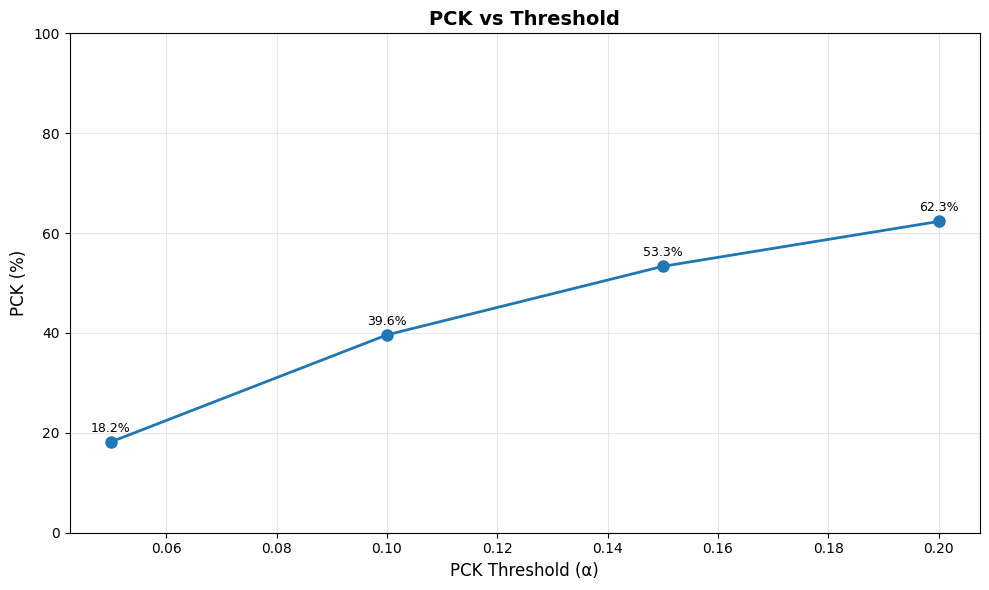

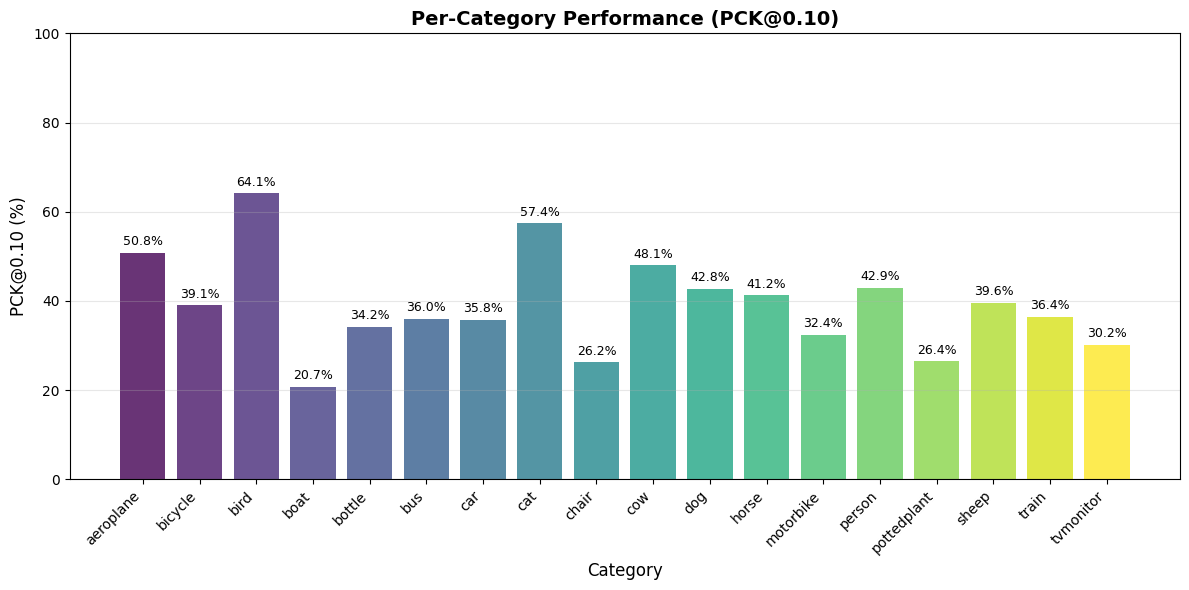

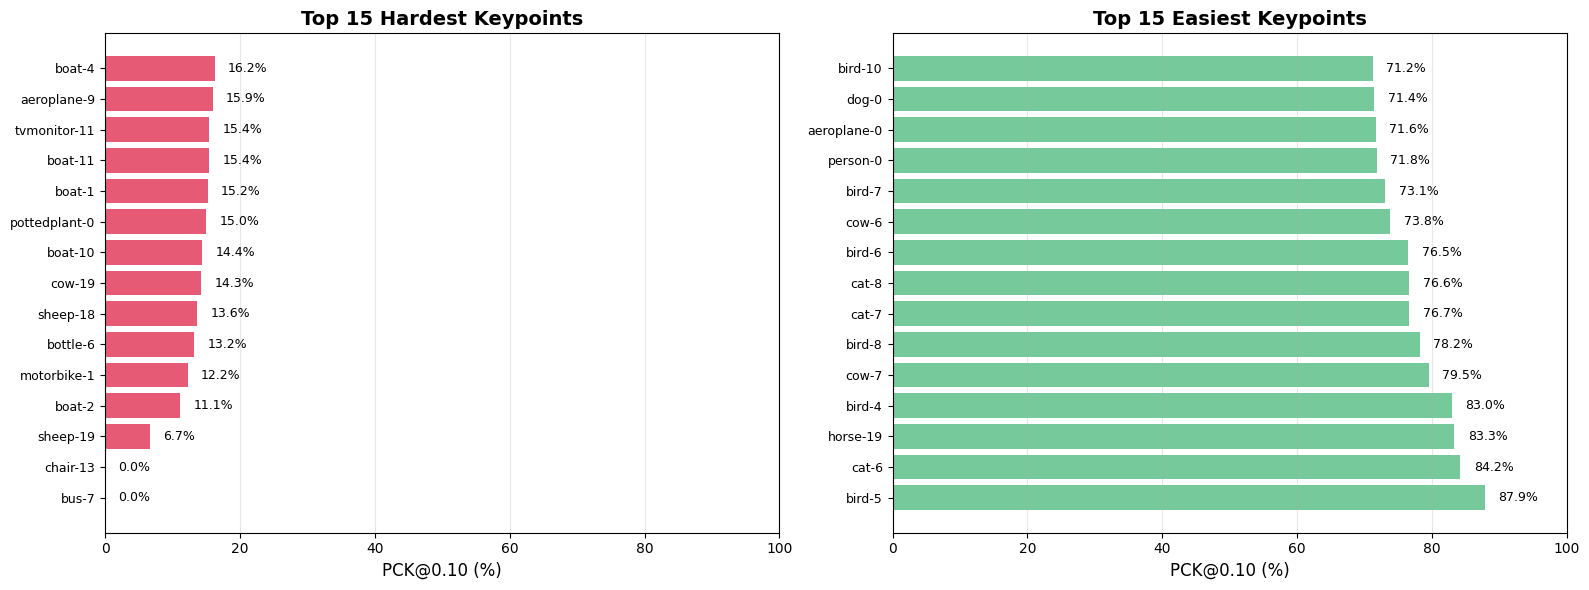

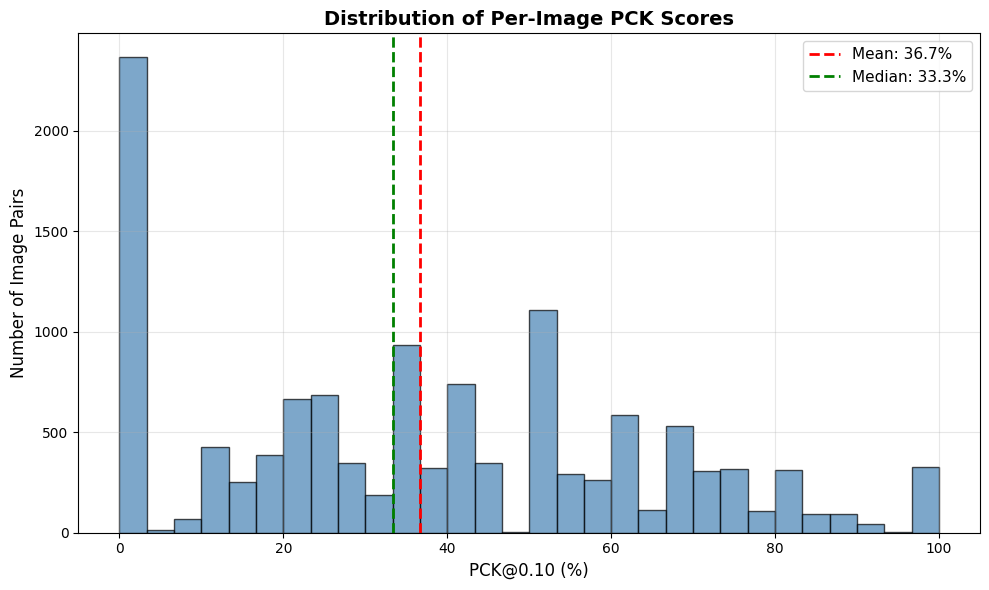

✅ Exported all metrics to ./results/dinov3_vitb16/
✅ Report generated in ./results/dinov3_vitb16/
   Overall PCK  aeroplane    bicycle       bird       boat     bottle  \
0     39.61258   50.83606  39.084325  64.121435  20.702894  34.179383   

         bus        car        cat      chair        cow        dog  \
0  35.975882  35.773942  57.373346  26.204819  48.058977  42.773844   

       horse  motorbike     person  pottedplant      sheep      train  \
0  41.220238  32.422105  42.946927    26.417183  39.552632  36.443418   

   tvmonitor  
0  30.220528  


In [ ]:
analyzer = ResultsAnalyzer(metrics)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/dinov3_vitb16')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)

# SAM

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qst2jjqd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qst2jjqd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=1a817cc6b7f0a7c24de118a4c04e704c3539a22436073528d197d09065560dfe
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkn9a9jw/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2026-01-05 21:05:11--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   288MB/s    in 1.2s    

2026-01-05 21:05:12 (288 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [ ]:
image_size = 1024 # Must be 1024
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='cat'
    )

dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k test annotations...


100%|██████████| 600/600 [00:00<00:00, 2071.30it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
checkpoint_path = "sam_vit_b_01ec64.pth"

In [ ]:
# Initialize model (SAM)
extractor = SAMExtractor(model_type="vit_b", checkpoint_path=checkpoint_path)
matcher = CorrespondenceMatcher(extractor)

# Evaluate
metrics = evaluate_model(matcher, dataloader)

Evaluating: 100%|██████████| 600/600 [08:13<00:00,  1.22it/s]


EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 25.70%
  PCK@0.10: 36.66%
  PCK@0.15: 45.85%
  PCK@0.20: 52.21%

📁 Per-Category PCK:
----------------------------------------------------------------------
  cat             → 0.05: 25.70% | 0.10: 36.66% | 0.15: 45.85% | 0.20: 52.21%

🎯 Per-Keypoint PCK (at α=0.10):
----------------------------------------------------------------------
  Top 10 easiest keypoints:
    cat             - Keypoint 4  : 50.00%
    cat             - Keypoint 6  : 50.00%
    cat             - Keypoint 7  : 44.00%
    cat             - Keypoint 5  : 43.83%
    cat             - Keypoint 1  : 43.81%
    cat             - Keypoint 2  : 43.33%
    cat             - Keypoint 3  : 42.03%
    cat             - Keypoint 8  : 39.18%
    cat             - Keypoint 0  : 38.95%
    cat             - Keypoint 9  : 19.17%

  Top 10 hardest keypoints:
    cat             - Keypoint 2  : 43.33%
    cat      

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "sam_vit_b"

results_dict = {
    'metrics': metrics,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")

Results saved!


📊 Generating visual report...


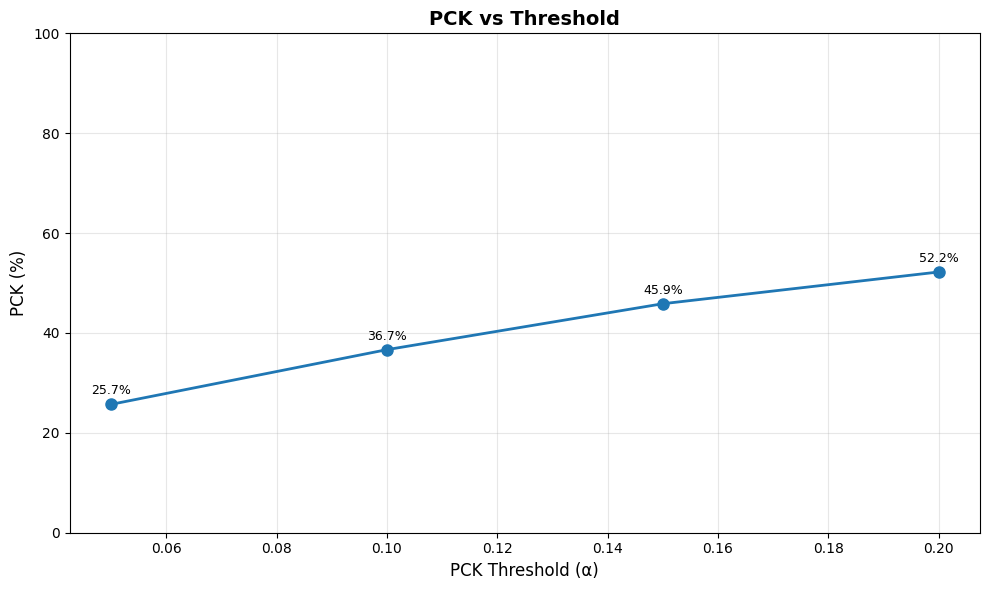

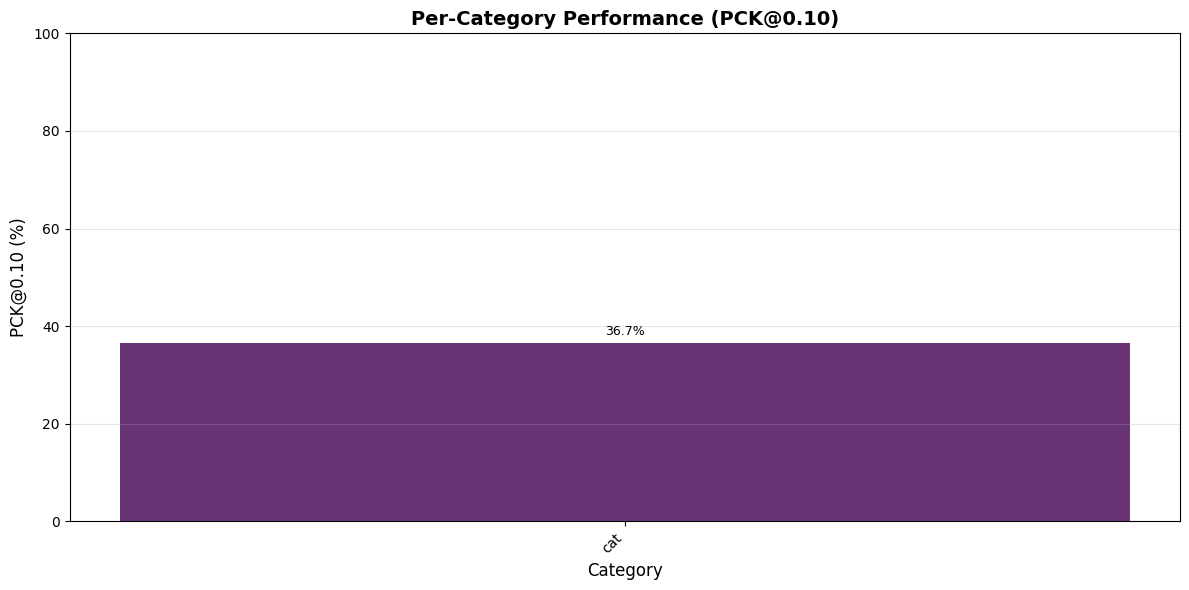

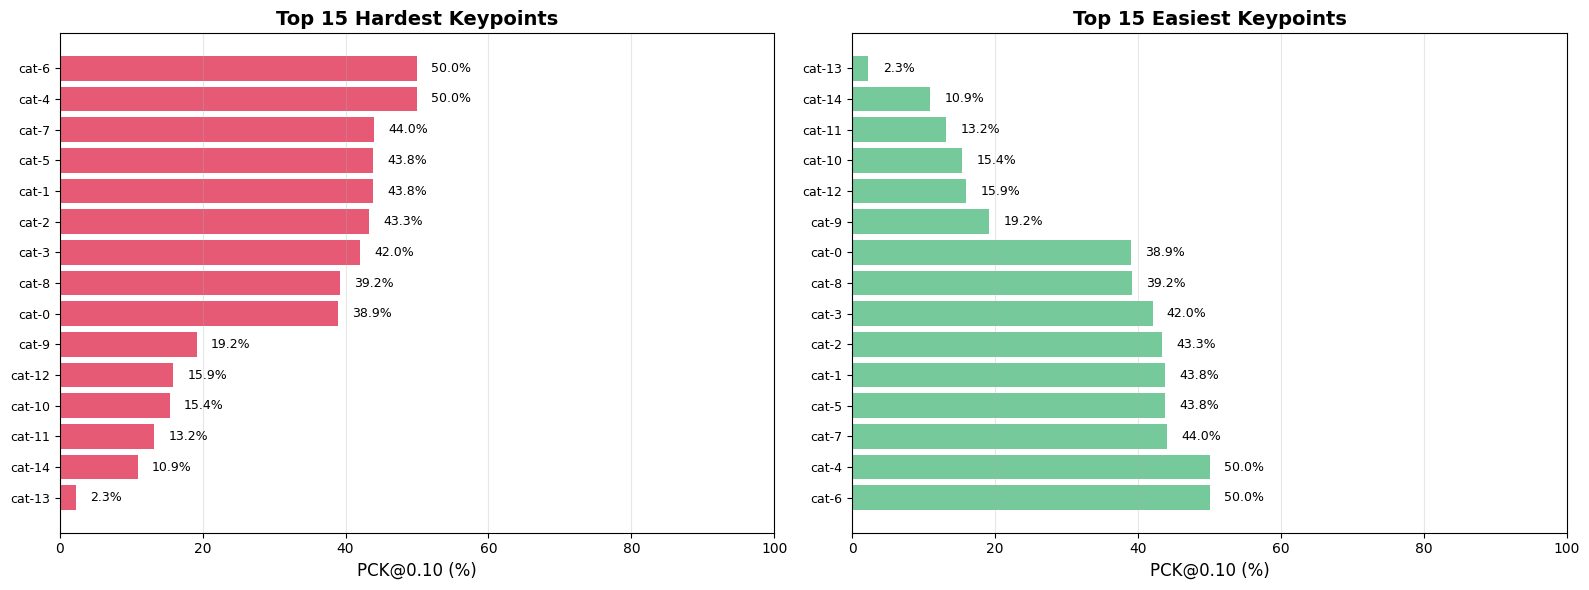

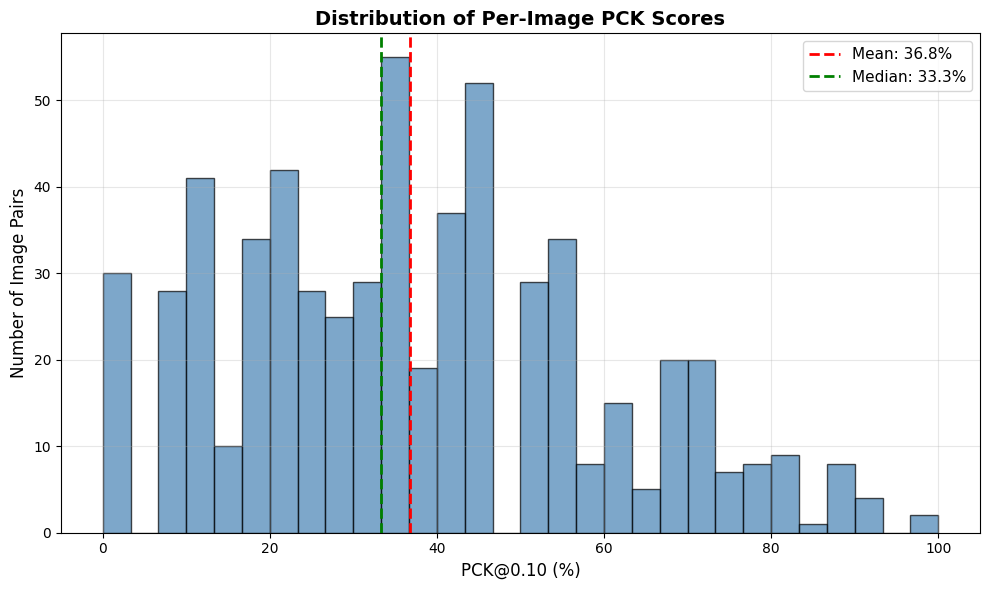

✅ Exported all metrics to ./results/sam_vit_b/
✅ Report generated in ./results/sam_vit_b/
✅ Exported all metrics to ./results/
   Overall PCK        cat
0    36.656986  36.656986


In [ ]:
analyzer = ResultsAnalyzer(metrics)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/sam_vit_b')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)

In [ ]:
# zipping the results for downloading
!zip -r results.zip results

Part fine-tunning


In [24]:
class CorrespondenceMatcher2:
    def __init__(self, feature_extractor):
        self.extractor = feature_extractor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def find_correspondences(self, src_img, trg_img, src_kps):
        """
        Version pour fine-tuning: renvoie les scores de similarité (différentiables)
        plutôt que des coordonnées.
        Returns:
            sim_matrix: [B, N, L]
            grid_size: (h_p, w_p)
            valid_mask: [B, N]
        """
        # Batch handling
        is_batched = src_img.dim() == 4
        if not is_batched:
            src_img = src_img.unsqueeze(0)
            trg_img = trg_img.unsqueeze(0)
            src_kps = src_kps.unsqueeze(0)

        # Move to device
        src_img = src_img.to(self.device)
        trg_img = trg_img.to(self.device)
        src_kps = src_kps.to(self.device)

        B, N, _ = src_kps.shape

        # Extract features
        src_feats, (h_p, w_p) = self.extractor.extract(src_img, no_grad=False)
        trg_feats, _ = self.extractor.extract(trg_img, no_grad=False)

        D = src_feats.shape[-1]
        patch_size = self.extractor.patch_size

        # Normalize for cosine similarity
        src_feats = F.normalize(src_feats, dim=-1)
        trg_feats = F.normalize(trg_feats, dim=-1)

        # Valid keypoints
        valid_mask = (src_kps[..., 0] >= 0)  # [B,N]

        # Source keypoints (pixels) -> patch indices
        kps_grid = (src_kps / patch_size).long()
        grid_x = kps_grid[..., 0].clamp(0, w_p - 1)
        grid_y = kps_grid[..., 1].clamp(0, h_p - 1)
        flat_indices = grid_y * w_p + grid_x  # [B,N]

        # Gather source features at keypoint locations
        flat_indices_expanded = flat_indices.unsqueeze(-1).expand(-1, -1, D)  # [B,N,D]
        src_kp_feats = torch.gather(src_feats, 1, flat_indices_expanded)      # [B,N,D]

        # Similarity scores (DIFFÉRENTIABLE)
        sim_matrix = torch.bmm(src_kp_feats, trg_feats.transpose(1, 2))       # [B,N,L]

        # Si input non batché, on peut squeeze les masks si tu veux, mais pas obligatoire
        return sim_matrix, (h_p, w_p), valid_mask


def kps_to_flat_indices(kps, patch_size, h_p, w_p):
    kps_grid = (kps / patch_size).long()
    grid_x = kps_grid[..., 0].clamp(0, w_p - 1)
    grid_y = kps_grid[..., 1].clamp(0, h_p - 1)
    return grid_y * w_p + grid_x  # [B,N]


def correspondence_loss_ce(sim_matrix, trg_kps, patch_size, h_p, w_p, valid_src_mask, tau=0.07):
    """
    sim_matrix: [B,N,L]
    trg_kps: [B,N,2] keypoints annotés dans l'image cible (-2 si invalide)
    """
    B, N, L = sim_matrix.shape
    trg_kps = trg_kps.to(sim_matrix.device)

    valid = valid_src_mask & (trg_kps[..., 0] >= 0)  # [B,N]
    labels = kps_to_flat_indices(trg_kps, patch_size, h_p, w_p)  # [B,N]

    logits = (sim_matrix / tau).reshape(B * N, L)
    labels = labels.reshape(B * N)
    mask = valid.reshape(B * N)

    logits = logits[mask]
    labels = labels[mask]

    if logits.shape[0] == 0:
        return None

    return F.cross_entropy(logits, labels)



In [2]:


# utilise TA loss existante
# from ton_fichier_loss import correspondence_loss_ce

def unfreeze_last_blocks_dino(model, n_last_blocks=1):
    """
    Gèle tout puis dégèle les n derniers blocs du ViT (DINO).
    """
    for p in model.parameters():
        p.requires_grad = False

    if not hasattr(model, "blocks"):
        raise AttributeError("Le modèle n'a pas d'attribut .blocks (ViT). Adapte unfreeze_last_blocks_dino().")

    for blk in model.blocks[-n_last_blocks:]:
        for p in blk.parameters():
            p.requires_grad = True


def make_optimizer(model, lr=2e-5, weight_decay=0.01):
    params = [p for p in model.parameters() if p.requires_grad]
    if len(params) == 0:
        raise ValueError("Aucun paramètre entraînable. Vérifie unfreeze_last_blocks_dino().")
    return torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)


def train_stage2(
    matcher,
    train_loader,
    n_epochs=1,
    n_last_blocks=1,
    lr=2e-5,
    weight_decay=0.01,
    tau=0.07,
    max_batches_per_epoch=None,
    use_amp=True,
):
    """
    Fine-tuning étape 2 avec ta fonction matcher.find_correspondences() + correspondence_loss_ce().
    """
    model = matcher.extractor.model

    # 1) Unfreeze last layers
    unfreeze_last_blocks_dino(model, n_last_blocks=n_last_blocks)

    # 2) Optimizer
    optimizer = make_optimizer(model, lr=lr, weight_decay=weight_decay)

    # 3) Train mode
    model.train()

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and torch.cuda.is_available()))
    patch_size = matcher.extractor.patch_size
    print("nb trainable params:", sum(p.requires_grad for p in model.parameters()))
    for epoch in range(n_epochs):
        running = 0.0
        steps = 0

        pbar = tqdm(train_loader, desc=f"Stage2 epoch {epoch+1}/{n_epochs}")
        for i, batch in enumerate(pbar):
            if max_batches_per_epoch is not None and i >= max_batches_per_epoch:
                break

            src_img = batch["src_img"]
            trg_img = batch["trg_img"]
            src_kps = batch["src_kps"]
            trg_kps = batch["trg_kps"]

            optimizer.zero_grad(set_to_none=True)

            if scaler.is_enabled():
                with torch.cuda.amp.autocast():
                    sim_matrix, (h_p, w_p), valid_mask = matcher.find_correspondences(src_img, trg_img, src_kps)
                    loss = correspondence_loss_ce(sim_matrix, trg_kps, patch_size, h_p, w_p, valid_mask, tau=tau)
                if loss is None:
                    continue
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                sim_matrix, (h_p, w_p), valid_mask = matcher.find_correspondences(src_img, trg_img, src_kps)
                loss = correspondence_loss_ce(sim_matrix, trg_kps, patch_size, h_p, w_p, valid_mask, tau=tau)
                if i == 0:  # juste au 1er batch
                     print("cuda available:", torch.cuda.is_available())
                     print("matcher.device:", matcher.device)

                     # est-ce qu'il y a des params entraînables ?
                     model = matcher.extractor.model
                     print("trainable params:", sum(p.requires_grad for p in model.parameters()))

                     # est-ce que le forward est différentiable ?
                     print("sim_matrix.requires_grad:", sim_matrix.requires_grad)
                     print("loss.requires_grad:", loss.requires_grad)

                if loss is None:
                    continue
                loss.backward()
                optimizer.step()

            running += float(loss.item())
            steps += 1
            pbar.set_postfix(loss=running / max(1, steps))

        print(f"Epoch {epoch+1}: avg loss = {running / max(1, steps):.6f}")

    return matcher  # le matcher contient le modèle mis à jour




In [25]:
extractor = DINOv2Extractor(model_name="dinov2_vitb14")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [19]:
image_size = 224 # Images must be multiples of 14 for DINOv2 or 16 for DINOv3.
dataset = SPairDataset(
        datapath='.',
        split='trn',
        img_size=image_size,
        category='all'
    )

train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k trn annotations...


100%|██████████| 53340/53340 [00:07<00:00, 6746.00it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [26]:

matcher = CorrespondenceMatcher2(extractor)
matcher = train_stage2(
    matcher=matcher,
    train_loader=train_loader,
    n_epochs=2,            # 1-3
    n_last_blocks=1,       # 1 sur Colab
    lr=2e-5,
    weight_decay=0.01,
    tau=0.07,
    max_batches_per_epoch=500,  # pour limiter le temps (optionnel)
    use_amp=True
)

/tmp/ipython-input-1826520680.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and torch.cuda.is_available()))


nb trainable params: 14


Stage2 epoch 1/2:   0%|          | 0/3334 [00:00<?, ?it/s]/tmp/ipython-input-1826520680.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Stage2 epoch 1/2:  15%|█▍        | 500/3334 [02:01<11:26,  4.13it/s, loss=2.51]


Epoch 1: avg loss = 2.508400


Stage2 epoch 2/2:  15%|█▍        | 500/3334 [02:00<11:24,  4.14it/s, loss=1.68]

Epoch 2: avg loss = 1.675219


In [28]:
# On réutilise le même extractor (poids fine-tunés)
matcher_eval = CorrespondenceMatcher(extractor)
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='all'
    )

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

metrics_after = evaluate_model(matcher_eval, dataloader)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov2_vitb14"

results_dict = {
    'metrics': metrics_after,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")
analyzer = ResultsAnalyzer(metrics_after)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/dinov2_vitb14_finetunened')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)

Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:01<00:00, 6849.60it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 765/765 [06:23<00:00,  1.99it/s]


EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 34.94%
  PCK@0.10: 60.60%
  PCK@0.15: 71.92%
  PCK@0.20: 78.68%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 48.36% | 0.10: 69.39% | 0.15: 77.55% | 0.20: 83.33%
  bicycle         → 0.05: 32.36% | 0.10: 56.23% | 0.15: 68.91% | 0.20: 75.14%
  bird            → 0.05: 48.00% | 0.10: 77.71% | 0.15: 87.05% | 0.20: 93.40%
  boat            → 0.05: 21.41% | 0.10: 42.97% | 0.15: 57.18% | 0.20: 65.89%
  bottle          → 0.05: 27.28% | 0.10: 51.17% | 0.15: 61.09% | 0.20: 66.74%
  bus             → 0.05: 36.65% | 0.10: 64.31% | 0.15: 74.14% | 0.20: 79.63%
  car             → 0.05: 33.69% | 0.10: 60.11% | 0.15: 69.79% | 0.20: 75.42%
  cat             → 0.05: 60.57% | 0.10: 80.41% | 0.15: 85.82% | 0.20: 89.53%
  chair           → 0.05: 30.72% | 0.10: 48.69% | 0.15: 54.57% | 0.20: 59.75%
  cow             → 0.0

NameError: name 'metrics' is not defined